In [1]:
import numpy as np
import sys, pickle, csv
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocess

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # memory increase is needed before starting program
        print(e)


ModuleNotFoundError: No module named 'XAI_method'

In [8]:
# load dataset

image_dim = 384


#dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = 'D:kvasir_cls'
class_list = ['esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

with open("D:/"+"kvasir" + "/kvasir_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)


(7000, 384, 384, 3) (7000, 1)
(1000, 384, 384, 3) (1000, 1)
total class number:  8
trn.shape (5600, 384, 384, 3) (5600, 8)
val.shape (1200, 384, 384, 3) (1200, 8)
tst.shape (1200, 384, 384, 3) (1200, 8)
(1000, 384, 384, 3) (1000, 384, 384)


In [12]:
base_model = Xception(weights = 'imagenet', pooling='avg', include_top = False)
preprocess_func = Xception_preprocess

predictions = Dense(8, activation='softmax')(base_model.output)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
last_conv_layer_name = "block14_sepconv2_act"

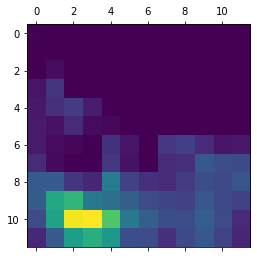

In [14]:
heatmap = make_gradcam_heatmap(X_trn_s[0], model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

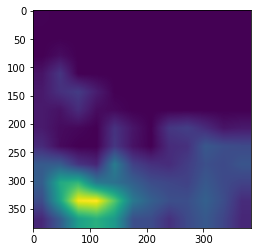

In [15]:
heatmap = cv2.resize(heatmap, (image_dim, image_dim))
plt.imshow(heatmap)

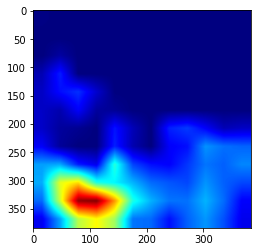

In [16]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

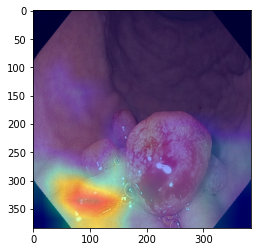

In [17]:
superimposed_img = (heatmap * 0.4 + X_trn_s[0] * 0.6).astype('uint8')
plt.imshow(superimposed_img)

In [ ]:
def gradcam_evaluation(gradcam_heatmap, Y_tst):
    gradcam_heatmap = cv2.resize(gradcam_heatmap, (image_dim, image_dim))
    fpr, tpr, _ = roc_curve(Y_tst.ravel(), gradcam_heatmap.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [21]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3 
    #"Input to deprocess image must be an image of "  "dimension [1, height, width, channel] or [height, width, channel]"
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [53]:
a = 1
a+= 2
a

3

In [33]:
preprocess_func = Xception_preprocess

In [26]:

def resnet_de(img_array):
    img_array /= 2.
    img_array += 0.5
    img_array *= 255.
    return img_array

In [34]:
preprocess_func(X_trn_s[0])

array([[[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       ...,

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]]

In [29]:
resnet_de(preprocess_func(X_trn_s[0])).max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


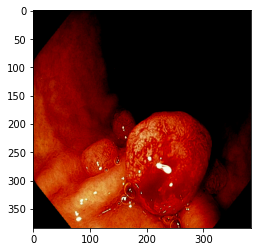

In [35]:
plt.imshow(preprocess_func(X_trn_s[0]))

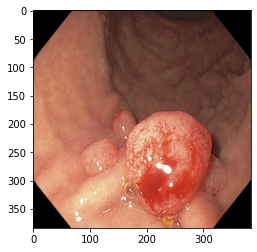

In [36]:
plt.imshow(resnet_de(preprocess_func(X_trn_s[0])).astype('uint8'))

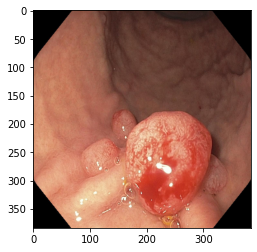

In [32]:
plt.imshow(X_trn_s[0])

In [64]:
deprocess_img(preprocess_func(X_trn_s[0]))

array([[[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]],

       [[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]],

       [[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]],

       ...,

       [[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]],

       [[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]],

       [[122, 115, 102],
        [122, 115, 102],
        [122, 115, 102],
        ...,
        [122, 115, 102],
        [122, 115, 102],
        [122, 115, 102]]